# "Thy algorithm shalt not bear false witness": An Evaluation of Multiclass Debiasing Methods on Word Embeddings


This is the code to support the paper ""Thy algorithm shalt not bear false witness": An Evaluation of Multiclass Debiasing Methods on Word Embeddings"
 It shows, which experiments and debiasing techniques are applied to word embedding word2vec.
The approaches are namely: 

Debiasing approaches: 
*   Conceptor Debiasing
*   Hard Debiasing
*   softWEAT

Evaluation Metrics: 
*   Relative Negative Sentiment Bias(RNSB) Metric
*   Mean Average Cosine Similarity (MAC) Metric
*   Word Association Evaluation Test (WEAT) effect size Metric

This Notebook refers to the W2V embeddings.

In [1]:
#Import needed Packages
from gensim.models import KeyedVectors
import numpy as np
import re
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.decomposition import PCA
from scipy.spatial.distance import cosine
import torch
import matplotlib.pyplot as plt
from scipy.linalg import null_space as ns
from statistics import mean
from scipy.linalg import norm
from scipy import stats
import warnings
from itertools import combinations
import seaborn as sns;
import pandas as pd
import matplotlib.pyplot as plt


# Loading Word2Vec
The "pre-trained vectors trained on part of Google News dataset (about 100 billion words). The model contains 300-dimensional vectors for 3 million words and phrases." (https://code.google.com/archive/p/word2vec/)

In [2]:
#for work in juypter notebooks
model = KeyedVectors.load_word2vec_format("GoogleNews-vectors//GoogleNews-vectors-negative300.bin", binary=True)


# Data

Below the data for the debaising and evaluation methods are defined. 

The sets of words concerning a particular attribute class are taken from Popovic, Lemmerich and Strohmaier (2020).

In [3]:
sets = {'pleasant': ['caress', 'freedom', 'health', 'love', 'peace', 'cheer', 'friend', 'heaven', 'loyal', 'pleasure', 'diamond', 'gentle', 'honest', 'lucky', 'rainbow', 'diploma', 'gift', 'honor', 'miracle', 'sunrise', 'family', 'happy', 'laughter', 'paradise', 'vacation', 'joy', 'wonderful'],
        'unpleasant': ['abuse', 'crash', 'filth', 'murder', 'sickness', 'accident', 'death', 'grief', 'poison', 'stink', 'assault', 'disaster', 'hatred', 'pollute', 'tragedy', 'divorce', 'jail', 'poverty', 'ugly', 'cancer', 'kill', 'rotten', 'vomit', 'agony', 'prison', 'terrible', 'horrible'],
        'instruments': ['bagpipe', 'cello', 'guitar', 'lute', 'trombone', 'banjo', 'clarinet', 'harmonica', 'mandolin', 'trumpet', 'bassoon', 'drum', 'harp', 'oboe', 'tuba', 'bell', 'fiddle', 'harpsichord', 'piano', 'viola', 'bongo', 'flute', 'horn', 'saxophone'],
        'weapons': ['arrow', 'club', 'gun', 'missile', 'spear', 'dagger', 'harpoon', 'pistol', 'sword', 'blade', 'dynamite', 'hatchet', 'rifle', 'tank', 'bomb', 'firearm', 'knife', 'shotgun', 'teargas', 'cannon', 'grenade', 'mace', 'slingshot', 'whip'],
        'career': ['executive', 'management', 'professional', 'corporation', 'salary', 'office', 'business', 'career'],
        'family': ['home', 'parents', 'children', 'family', 'cousins', 'marriage', 'wedding', 'relatives'],
        'science': ['science', 'technology', 'physics', 'chemistry', 'einstein', 'nasa', 'experiment', 'astronomy'],
        'art': ['poetry', 'art', 'dance', 'literature', 'novel', 'symphony', 'drama', 'sculpture'], 
        'intellectual_words': ['resourceful', 'inquisitive', 'sagacious', 'inventive', 'adaptable', 'intuitive', 'analytical', 'imaginative', 'shrewd', 'thoughtful', 'smart', 'clever', 'brilliant', 'logical', 'intelligent', 'apt', 'genius', 'wise', 'stupid', 'dumb', 'dull', 'clumsy', 'foolish', 'naive', 'unintelligent'],
        'appearance_words': ['alluring', 'voluptuous', 'blushing', 'homely', 'plump', 'sensual', 'gorgeous', 'slim', 'bald', 'athletic', 'fashionable', 'stout', 'ugly', 'muscular', 'slender', 'feeble', 'handsome', 'healthy', 'attractive', 'fat', 'weak', 'thin', 'pretty', 'beautiful', 'strong'], 
        'shy': ['soft', 'quiet', 'compromising', 'rational', 'calm', 'kind', 'agreeable', 'servile', 'pleasant', 'cautious', 'friendly', 'supportive', 'nice', 'mild', 'demure', 'passive', 'indifferent'],
        'aggressive': ['shrill', 'loud', 'argumentative', 'irrational', 'angry', 'abusive', 'obnoxious', 'controlling', 'nagging', 'brash', 'hostile', 'mean', 'harsh', 'sassy', 'aggressive', 'opinionated', 'domineering'],
        'competent': ['competent', 'productive', 'effective', 'ambitious', 'active', 'decisive', 'strong', 'tough'], 'incompetent': ['incompetent', 'unproductive', 'ineffective', 'passive', 'indecisive', 'weak', 'gentle', 'timid'],
        'likeable': ['agreeable', 'fair', 'honest', 'trustworthy', 'selfless', 'accommodating'],
        'unlikeable': ['abrasive', 'conniving', 'manipulative', 'dishonest', 'selfish', 'pushy']}

In [4]:
attributes = sets.copy()

In order to establish a common base of identity terminology of groups used to debias the word embedding, an equality set of words is built. The choice for equality sets stems from the fact that hard debiasing requires equality sets to debias. With the use of the same equality set in each method, a more meaningful comparison can be made. 

The equality set was built by hand, with some notions taken from Manzini, Lim, Tsvetkov and Black (2019) equality sets.

In [5]:
sets['judaism_words'] = ['judaism', 'jew','jews','synagogue','synagogues', 'torah', 'rabbi', 'rabbis', 
                         'abraham', 'star', 'shabbat']
sets['christianity_words'] = ['christianity','christian','christians','church','churches','bible','priest','priests',
                             'jesus','cross','easter']
sets['islam_words'] = ['islam','muslim','muslims','mosque','mosques','quran','imam','imams','muhammad',
                        'hilal','ramadan']

In [6]:
equality_sets = [
        ["judaism", "christianity", "islam"],
        ["jew", "christian", "muslim"],
        ["jews", "christians", "muslims"],
        ["synagogue", "church", "mosque"],
        ["synagogues", "churches", "mosques"],
        ["torah", "bible", "quran"],
        ["rabbi", "priest", "imam"],
        ["rabbis", "priests", "imams"],
        ["abraham", "jesus", "muhammad"],
        ["star", "cross", "hilal"],
        ["shabbat", "easter", "ramadan"],
    
]

In [7]:
#for testing of MAC for Religion specific average cosine  distance to attribute sets. This was done for the analysis of the 
#poor performance of hard debiasing within MAC 
mequality_sets = [
    ['judaism', 'jew','jews','synagogue','synagogues', 'torah', 'rabbi', 'rabbis', 
                         'abraham', 'star', 'shabbat'],
    ['christianity','christian','christians','church','churches','bible','priest','priests',
                             'jesus','cross','easter'],
    ['islam','muslim','muslims','mosque','mosques','quran','imam','imams','muhammad',
                        'hilal','ramadan']
    
]

# Bias Evaluations

In [8]:
Results = {}

## Relative Negative Sentiment Bias (RNSB)
The first evaluation method will be the RNSB metric. It imitates the results, which would be given to a downstream application.
The relative negative sentiment bias is an approach proposed by Sweeney and Najafan (2019) in order to offer insights on the effect of biased word embeddings through downstream applications. Its framework involves training a logistic classifier to predict the positive or negative sentiment of a given word. The classifier is trained on unbiased sentiment words, which are encoded via the word embedding to be investigated. Sweeney and Najafan then encode demographic identity terms and predict their respective negative sentiment probability. These results are used to form a probability distribution P. The Relative Negative Sentiment Bias (RNSB) is then defined "as the KL
divergence of P from U, where U is the uniform
distribution". 

The RNSB metric will be calculated for each debiasing method. To  intrepret this metric, Sweeney and Najafian state that "Our RNSB metric captures the distance, via KL divergence, between the current distribution of negative sentiment and the fair uniform distribution. So the more fair a word embedding model with respect to sentiment bias, the lower the RNSB metric."

*(Sweeney, C., & Najafian, M. (2019, July). A Transparent Framework for Evaluating Unintended Demographic Bias in Word Embeddings. In Proceedings of the 57th Annual Meeting of the Association for Computational Linguistics (p. 1664).)*

In [9]:
def readInReview(reviewName):
    firstReview = open(reviewName, "r")
    review = firstReview.read()
    #Each list element is a word or title
    reviewList = re.split(r'\n', review)
    #remove introduction to dataset
    count = 0
    for x in reviewList:
        if x.startswith(';'):
            count +=1
        else:
            break
    reviewList = reviewList[count:]
    return reviewList

In [10]:
def create_embeddings(model_Encoding,review):
    embedding_matrix = []
    for x in review:
        if x in model.vocab:
            embedding_matrix.append(model_Encoding(x))
    embedding_matrix = np.array(embedding_matrix)
    return embedding_matrix

In [11]:
def calculateRNSB(results):
    negProbResults = []
    negProbSum = 0
    for x in results:
        negProbResults.append(x[0])
        negProbSum += x[0]

    normalizedResults = []
    for i in range(len(results)): 
        normalizedResults.append(negProbResults[i]/negProbSum)
        
    #KL Divergence
    RNSB = 0
    Q = 1/len(normalizedResults)
    for x in normalizedResults:
        RNSB += x * np.math.log((x / Q))
    return RNSB

In [12]:
def RNSB_Evaluation(model_Encoding,identity_words,p_val = True):
    '''
    model_encoding: methodcall to get a word embedding for a word
    identity_words: equaluty sets to be tested
    p_val: whether a one tailed t test on the distribution of the values should be performed
    returns: RNSB score, p value and average RNSB scores for each equality set
    
    '''
    warnings.filterwarnings("ignore")
    #Train logistic classifier on unbiased positive /negative sentiment words
    reviewNeg = readInReview("opinion-lexicon-English\\negative-words.txt")
    neg = create_embeddings(model_Encoding,reviewNeg)
    targetN = np.zeros(np.size(neg,0))
    reviewPos = readInReview("opinion-lexicon-English\\positive-words.txt")
    pos = create_embeddings(model_Encoding,reviewPos)
    targetP = np.ones(np.size(pos,0))
    embed = np.concatenate((pos,neg))
    target = np.concatenate((targetP,targetN))
    
    #Train, (Validation) and Test set 
    rnsb_values = []
    stats = np.zeros(len(identity_words))
    islam_val, christ_val, juda_val = [], [],[]
    # for 20 runs
    for n in range (0, 20):
        itrain, itest = train_test_split(range(embed.shape[0]), test_size=0.2)

        X_train = embed[itrain, :]
        X_test = embed[itest, :]
        y_train = target[itrain]
        y_test = target[itest]


        logisticReg = LogisticRegression()
        logisticReg.fit(X_train,y_train)
        logpredy = logisticReg.predict(X_test)
        
        #print("Accuracy:",metrics.accuracy_score(y_test, logpredy))
        #print("Recall:", metrics.recall_score(y_test, logpredy))
        #print("Precision:", metrics.precision_score(y_test, logpredy))
        #print("F1: ", metrics.f1_score(y_test, logpredy))
        
        RNSB = []
        juda, christ, islam = [],[],[]
        for iset in identity_words: 
            identity_embed= []
            for i in iset:
                if not model_Encoding(i) == 'None':
                    identity_embed.append(model_Encoding(i))
            identity_pred = logisticReg.predict_proba(identity_embed)
            juda.append(identity_pred[0][0])
            christ.append(identity_pred[1][0])
            islam.append(identity_pred[2][0]) 
            temp = calculateRNSB(identity_pred)
            RNSB.append(temp)
                
        juda_val.append(mean(juda))
        christ_val.append(mean(christ))
        islam_val.append(mean(islam)) 
        RNSB = np.array(RNSB)
        rnsb_values.append(np.mean(RNSB))
        stats = np.add(stats,RNSB)
    j = mean(juda_val)
    c = mean(christ_val)
    i = mean(islam_val)
    #averafe relative negative sentiment for each religion over various equality sets
    print ('judaism ', j, 'christ', c, ' islam', i)
    stats = np.divide(stats,20)
    if p_val:
        _,RNSBnonDB_target_eval,_ = RNSB_Evaluation(encode_nondebias,equality_sets,p_val = False)
        p_val = ttest_p(RNSBnonDB_target_eval, stats)
    else:
        p_val = 0

    score = mean(rnsb_values)
    print('average over 20 ', score, stats)
    return score, stats, p_val

## Mean Average Cosine Similarity (MAC)
The second evalutation method is the Mean Average Cosine Similarity (MAC) as proposed by Manzini et al. The method originates from the notion of the WEAT test implemented below, but allows for quantification of multiclass bias.

The approach uses Target sets T, which are identity terms for a protected group, and thus inherently carry some bias, and attribute sets A containing terms that should not be linked to the target sets above (pleasent, unpleasent). The MAC metric is acquired by calculating the mean over the cosine distances between each element in a particular set T to each element in a particular set A. This is repeated for each set T with respect to each set A. The MAC is then the average result over all sets.

The cosine distance ranges from 0 to 2, 0 indicating that the vectors are the same and 2 indicating that the vectors have maximum cosine distance. Thus, to interpret the MAC metric, one should ideally expect a MAC value of close to 1. This would indicate that the target sets are as close to an attribute set, as they are distant from it.

*(Manzini, T., Lim, Y. C., Tsvetkov, Y., & Black, A. W. (2019). Black is to criminal as caucasian is to police: Detecting and removing multiclass bias in word embeddings. arXiv preprint arXiv:1904.04047.)*

In [13]:
def multiclass_evaluation(word_encoding, calculate_p_val = True):
    '''
    word_encoding : methodcall to get a word embedding for a word
    calculate_p_val : whether a p value for the one tailed t test should be caluclated 
    returns MAC score, p value, individual MAC scores for each equality sets
    '''
    targets_eval = []
    
    for targetSet in equality_sets:
        inestigatTemp = []
        for target in targetSet:
            if word_encoding(target) != 'None':
                for attributeSet in attributes:
                    res = 0
                    count = 0
                    for a in attributeSet: 
                        if word_encoding(a)!= 'None':
                            t_embed = word_encoding(target)
                            a_embed = word_encoding(a)
                            #print(t_embed.dtype, a_embed.dtype)
                            temp = cosine(t_embed,a_embed)
                            res+= temp
                            count += 1
                            #print(f'{target} and {a} : {temp}')
                    #print(target, attributeSet,(res/count) )
                    targets_eval.append((res/count))
                    inestigatTemp.append((res/count))
        print(targetSet, ':', np.mean(inestigatTemp))
    if calculate_p_val: 
        _,_,nonDB_target_eval = multiclass_evaluation(encode_nondebias, False)
        p_val = ttest_p(nonDB_target_eval,targets_eval)
    else: 
        p_val = 0
    print('score:', np.sum(targets_eval)/(len(targets_eval)))
    m_score = np.mean(targets_eval)
    return m_score, p_val, targets_eval

In [14]:
def ttest_p(nonDB_target_eval, target_eval):
    '''
    nonDB_target_eval: first distribution
    target_eval: second distribution
    returns p value of a one taile dt test between the two distributions
    '''
    diff = []
    #differences between non debias and this method
    for i in range(len(target_eval)):
        diff.append(target_eval[i]- nonDB_target_eval[i])    
    diff = np.array(diff)
    std = np.std(diff)
    mean = np.mean(diff)
    st_error = std/(np.sqrt(len(diff)))
    test_stat = mean/st_error
    p_val = stats.t.sf(np.absolute(test_stat),df=len(diff)-1)
    print('test stat', test_stat)
    print('p ', p_val )
    return p_val

## Word Evaluation Association Test (WEAT) Effect Size
The WEAT also utilizes target and attribute sets as defined above. The WEAT considers two target and two attribute sets simultaeneously. It tests the association between one target and attribute set, relative to the association of the other target and attribute set. "null hypothesis is that there is no difference between the two sets of target
words in terms of their relative similarity to the two sets of attribute words"


To perform the WEAT test, the mean cosine similarity of an element in target set T1 to all elements in attribute set A2 is subtracted from the mean cosine similarity to all elements in attribute set A1. The sum of this is taken for all elements of T1. From this the sum for all elements in T2 is subtracted. This value is defined as the test statistic. 

To obtain the effect size, which is "a normalized measure of how separated the two distributions (of associations between the target and attribute) are" (Caliskan et al, 2017), the mean of the mean cosine similarity of each target of a target set T1 to each attribute set is taken. From this the mean of the mean cosine similarity of each target of a target set T2 to each attribute set is subtracted. To normalize this, this value is devided by the standard deviation over the mean cosine distance of each target in T1 and T2 to attribute set A1 minus that to attribute set A2. 

The loewer the effect size d is, i.e. the closer to zero, the less bias can be recorded between the target and attribute sets.


*(Caliskan, A., Bryson, J. J., & Narayanan, A. (2017). Semantics derived automatically from language corpora contain human-like biases. Science, 356(6334), 183-186.)*

The 'religion' dictionary defines logical combinations for attribute sets. Each of these is defined for each combination of target sets. (Sets againare taken from Popovic et al.'s work (2020))

In [15]:
religion ={('islam_words', 'judaism_words'): [('likeable', 'unlikeable'), ('competent', 'incompetent'), 
                                                 ('shy', 'aggressive'), ('intellectual_words', 'appearance_words'),
                                                 ('family', 'career'), ('instruments', 'weapons'), 
                                                 ('pleasant', 'unpleasant'), ('science', 'art')], 
           
              ('islam_words', 'christianity_words'): [('likeable', 'unlikeable'), ('competent', 'incompetent'),
                                                      ('shy', 'aggressive'), ('intellectual_words', 'appearance_words'),
                                                      ('family', 'career'), ('instruments', 'weapons'), 
                                                      ('pleasant', 'unpleasant'), ('science', 'art')], 
           
              ('judaism_words', 'christianity_words'): [('likeable', 'unlikeable'), ('competent', 'incompetent'), 
                                                        ('shy', 'aggressive'), ('intellectual_words', 'appearance_words'),
                                                        ('family', 'career'), ('instruments', 'weapons'), 
                                                        ('pleasant', 'unpleasant'), ('science', 'art')]
          }

In [16]:
def WEAT_Effect_size(x,y,a,b):
        numerator = np.mean([h(w,a,b) for w in x]) - np.mean([h(w,a,b) for w in y])
        denominator = np.std([h(w,a,b) for w in x + y])
        return numerator/denominator

In [17]:
def WEAT_p_val(X,Y,A,B):
    '''
    p value: probability that the statistic is of the value by chance
    '''
    stat = np.sum([h(w,A,B) for w in X]) -  np.sum([h(w,A,B) for w in Y])
    print('stat', stat)
    count = 0
    higher = 0
    #create all possible combinations
    Z = X+Y
    print(len(Z), len(list(combinations(range(len(Z)),len(Z)//2))))
    combos = []
    for combo in combinations(range(len(Z)), len(Z)//2):
        combos.append(combo)
        x = [Z[i] for i in combo]
        y = []
        for i in range(len(Z)):
            if i not in combo:
                y.append(Z[i])
        if(x not in combos and y not in combos):
            # calculate test statistic
            stat_temp = np.sum([h(w,A,B) for w in x]) -  np.sum([h(w,A,B) for w in y])
            count += 1
            if stat_temp > stat:
                higher += 1
        #print(count)
    p_val = higher/count 
    print('p_val', p_val)
    return p_val

In [18]:
def h(w,A,B):
    meanA = np.mean([cosine(w,a) for a in A])
    meanB = np.mean([cosine(w,b) for b in B])
    return (meanA - meanB)

In [19]:
def WEAT_Average_Effect_size(embedding_meth, biasToBeTested, p = False):
    '''
    embedding_meth: method call to get the word vector of a word
    biasToBeTested: attribute target set combinations (dict) 
    returns effect size d
    '''
    count = 0
    d_values = []
    p_values = []
    for category_target_pair in biasToBeTested:
        cat_0 = [embedding_meth(c) for c in sets[category_target_pair[0]]]
        cat_1 = [embedding_meth(c) for c in sets[category_target_pair[1]]]
        for attribute_pair in biasToBeTested[category_target_pair]:
            att_0 = [embedding_meth(a) for a in sets[attribute_pair[0]]]
            att_1 = [embedding_meth(a) for a in sets[attribute_pair[1]]]
            if p : 
                p_values.append(WEAT_p_val(cat_0,cat_1,att_0,att_1))
            d = WEAT_Effect_size(cat_0, cat_1, att_0, att_1)
            d_values.append(abs(d))          
    print(d_values) 
    return np.mean(d_values)

# Non-Debiased Word Embedding Evaluation

This is the word2vec model prior to any debiasing. It should perform the worst.

In [20]:
def encode_nondebias(word):
    if word in model.vocab:
        return model.get_vector(word)
    return 'None'

In [21]:
relBias,RNSBnonDB_target_eval,p = RNSB_Evaluation(encode_nondebias,equality_sets, False) 

judaism  0.5589326351558177 christ 0.6612342754523184  islam 0.8562495688071126
average over 20  0.12823775556463923 [0.00277317 0.05016296 0.00449369 0.01115461 0.0146937  0.55661426
 0.19707681 0.05558263 0.03022849 0.11165298 0.376182  ]


In [22]:
score,p2,t = multiclass_evaluation(encode_nondebias)

['judaism', 'christianity', 'islam'] : 0.7798762041004368
['jew', 'christian', 'muslim'] : 0.7779697438448442
['jews', 'christians', 'muslims'] : 0.8117313206891456
['synagogue', 'church', 'mosque'] : 0.9913475976506388
['synagogues', 'churches', 'mosques'] : 0.9812809082575095
['torah', 'bible', 'quran'] : 0.8595037080193201
['rabbi', 'priest', 'imam'] : 0.9981623588407634
['rabbis', 'priests', 'imams'] : 0.9899504226712583
['abraham', 'jesus', 'muhammad'] : 0.7449998714863378
['star', 'cross', 'hilal'] : 0.9370946496251209
['shabbat', 'easter', 'ramadan'] : 0.8314679134777648
['judaism', 'christianity', 'islam'] : 0.7798762041004368
['jew', 'christian', 'muslim'] : 0.7779697438448442
['jews', 'christians', 'muslims'] : 0.8117313206891456
['synagogue', 'church', 'mosque'] : 0.9913475976506388
['synagogues', 'churches', 'mosques'] : 0.9812809082575095
['torah', 'bible', 'quran'] : 0.8595037080193201
['rabbi', 'priest', 'imam'] : 0.9981623588407634
['rabbis', 'priests', 'imams'] : 0.989

In [23]:
Results['Nondebias*'] = [relBias, p, score,p2, WEAT_Average_Effect_size(encode_nondebias, religion)]

[0.26066891607626996, 0.40838164801997817, 0.005682144845930048, 0.4421097319788695, 0.4786866281807168, 1.2101514554789525, 0.9100249979993442, 0.41257207784203753, 0.28454531118961734, 0.7620611940494734, 0.030062573246757235, 0.2772419557116415, 0.30306180801277566, 0.7599421809029535, 1.0536442159511894, 0.31651217215973515, 0.018352683771000064, 0.2567078594016816, 0.023672850382630804, 0.17404635457394793, 0.15471786708628507, 0.8087072262644193, 0.041342490092856066, 0.07971854132974603]


## Debiasing via Concept Negator
Conceptor Debiasing (Karve, Ungar and Sedoc (2019))

In [24]:
def findNegatedConceptor(Z, aperture = 10):
    '''
    Find conceptor to debias with
    '''
    k = len(Z)
    Z_Trans = Z.transpose()
    C_1 = (1/k) * np.matmul(Z,Z_Trans)
    temp = (aperture**(-2)) * np.identity(300)
    C_2 = np.linalg.inv(np.add(C_1, temp))
    C = np.matmul(C_1,C_2)
    G = np.subtract(np.identity(300),C)
    return G

In [25]:
def encodeViaConceptorNegator(word):
    if word in model.vocab:
        word = model.get_vector(word)
        word = word / np.linalg.norm(word)
        return np.matmul(negConceptor,word) 
    return 'None'

In [26]:
#Target Words 
Z = sets['judaism_words']+sets['christianity_words']+sets['islam_words']
Z = list(set(Z))
Z_embed = []
for z in Z:
    #print(z)
    if z in model.vocab:
        Z_embed.append(model.get_vector(z))
Z_embed = np.array(Z_embed)
Z_embed  = Z_embed.transpose()
negConceptor = findNegatedConceptor(Z_embed)

In [27]:
relBias,_,p = RNSB_Evaluation(encodeViaConceptorNegator,equality_sets)

judaism  0.6297078201253618 christ 0.63394208964055  islam 0.6085346236678507
judaism  0.5764138341963406 christ 0.6742609959123592  islam 0.8587263033808307
average over 20  0.11773116501125165 [0.0030145  0.04375814 0.00331389 0.00625541 0.01622483 0.50234391
 0.1746793  0.06673468 0.03250383 0.10634404 0.33987031]
test stat -2.4076965237993293
p  0.018414037101185162
average over 20  0.0067377115121234 [0.00098419 0.00788754 0.00417143 0.00062324 0.00100111 0.00631655
 0.00380504 0.00231741 0.01060807 0.0181849  0.01821535]


In [28]:
score,p2,t = multiclass_evaluation(encodeViaConceptorNegator)

['judaism', 'christianity', 'islam'] : 0.9900593387721193
['jew', 'christian', 'muslim'] : 0.9921138288368686
['jews', 'christians', 'muslims'] : 1.0136340693732602
['synagogue', 'church', 'mosque'] : 0.999470531876395
['synagogues', 'churches', 'mosques'] : 0.9971036075651948
['torah', 'bible', 'quran'] : 0.9991911233595253
['rabbi', 'priest', 'imam'] : 1.0147167268321569
['rabbis', 'priests', 'imams'] : 0.9960338245917869
['abraham', 'jesus', 'muhammad'] : 0.9655393370766925
['star', 'cross', 'hilal'] : 0.9963705877581445
['shabbat', 'easter', 'ramadan'] : 0.9877862741683305
['judaism', 'christianity', 'islam'] : 0.7798762041004368
['jew', 'christian', 'muslim'] : 0.7779697438448442
['jews', 'christians', 'muslims'] : 0.8117313206891456
['synagogue', 'church', 'mosque'] : 0.9913475976506388
['synagogues', 'churches', 'mosques'] : 0.9812809082575095
['torah', 'bible', 'quran'] : 0.8595037080193201
['rabbi', 'priest', 'imam'] : 0.9981623588407634
['rabbis', 'priests', 'imams'] : 0.9899

In [29]:
Results['Conceptor_Debias*'] = [relBias, p,score,p2 ,WEAT_Average_Effect_size(encodeViaConceptorNegator, religion)]

[0.29812402016897077, 0.4563255952120053, 0.0705083078797554, 0.003929635285323497, 0.21810506347895486, 0.4834117625812987, 0.07644292033070908, 0.011928756117349483, 0.33797939753890416, 0.02897332034258196, 0.12636178173207893, 0.11911219921971636, 0.2117372292740326, 0.0047950677532390285, 0.07100262342086357, 0.22709179326729018, 0.08142424591290265, 0.3815649752241952, 0.06642440284748305, 0.09120378605877584, 0.04931580876661513, 0.43287610235017365, 0.011927060075353945, 0.24638146496735128]


## Debiasing via Hard Debiasing
Hard Debiaing Manzini et al. (2019)
Adapted from :https://github.com/TManzini/DebiasMulticlassWordEmbedding

In [30]:
def identify_bias_subspace(def_sets, subspace_dim, embedding_dim):
    """
    Similar to bolukbasi's implementation at
    https://github.com/tolga-b/debiaswe/blob/master/debiaswe/debias.py
    vocab - dictionary mapping words to embeddings
    def_sets - sets of words that represent extremes? of the subspace
            we're interested in (e.g. man-woman, boy-girl, etc. for binary gender)
    subspace_dim - number of vectors defining the subspace
    embedding_dim - dimensions of the word embeddings
    """
    # calculate means of defining sets # calculate vectors to perform PCA
    means = {} 
    matrix = []
    for term_list in def_sets:
        wSet = []
        for w in term_list:
            if w in model.vocab: 
                wSet.append(model.get_vector(w))

        set_vectors = np.array(wSet)
        means = np.mean(set_vectors, axis=0)
        diffs = set_vectors - means
        matrix.append(diffs)

    matrix = np.concatenate(matrix)

    pca = PCA(n_components=subspace_dim)
    pca.fit(matrix)

    return pca.components_


In [31]:
def project_onto_subspace(vector, subspace):
    '''
    returns v_b : projection of the vector onto the subspace
    '''
    v_b = np.zeros_like(vector)
    for component in subspace:
        v_b += np.dot(vector.transpose(), component) * component
    return v_b

In [32]:
def encodeHardDebias(word): 
    # is the word in the model vocab
    if word not in model.vocab: 
        return 'None'
    wordEmbed = model.get_vector(word)
    #if the word should contain bias, i.e. is found in following sets: 
    eq_sets = equality_sets
    eq_set =[]
    for i in eq_sets:
        if word in i:
            eq_set = i
    # is the word in a set
    if len(eq_set) != 0:
    #embed the set, and simultaeneuosly compute the mean
        mean = np.zeros((300,))
        cleanEqSet = []    
        for w in eq_set:
            if w in model.vocab and not w == word:
                v = model.get_vector(w)
                v = v / np.linalg.norm(v)
                mean += v
                cleanEqSet.append(v)
            elif w == word:
                wordEmbed = wordEmbed/np.linalg.norm(wordEmbed)
                mean += wordEmbed
        mean /= float(len(cleanEqSet))
        #bias subspace component of the mean
        mean_b = project_onto_subspace(mean, bias_subspace)
        upsilon = mean - mean_b
        v_b = project_onto_subspace(wordEmbed, bias_subspace)
        frac = (v_b - mean_b) / np.linalg.norm(v_b - mean_b)
        wordEmbed = upsilon + np.sqrt(1 - np.square(np.absolute(upsilon))) * frac
        return wordEmbed
    # if it should not contain any bias
    v_b = project_onto_subspace(wordEmbed, bias_subspace)
    wordEmbed = (wordEmbed - v_b) / np.linalg.norm(wordEmbed - v_b)

    return wordEmbed

In [33]:
#definite sets and equality sets
bias_subspace = identify_bias_subspace(equality_sets, 1, 300 )
#make bias subsapce 2d
if bias_subspace.ndim == 1:
    bias_subspace = np.expand_dims(bias_subspace, 0)
elif bias_subspace.ndim != 2:
    raise ValueError("bias subspace should be either a matrix or vector")

In [34]:
relBias,_,p = RNSB_Evaluation(encodeHardDebias,equality_sets)

judaism  0.6965450544858384 christ 0.6965450633807678  islam 0.696740432442311
judaism  0.5815842325531919 christ 0.6730430284905986  islam 0.8533007079948625
average over 20  0.11832997081623726 [0.00252362 0.04699935 0.00374248 0.00514197 0.01675147 0.52527554
 0.15681514 0.05861417 0.03401117 0.08832383 0.36343094]
test stat -2.4026285100834492
p  0.01857421168741203
average over 20  6.99909438110394e-07 [4.25335610e-08 6.30823048e-10 7.93835940e-09 2.66438703e-08
 4.29301194e-07 8.65088726e-07 1.60063827e-07 3.94313537e-09
 1.47101427e-07 3.90407830e-07 5.62535107e-06]


In [35]:
score,p2,t = multiclass_evaluation(encodeHardDebias)

['judaism', 'christianity', 'islam'] : 0.796114061487387
['jew', 'christian', 'muslim'] : 0.7933538217254936
['jews', 'christians', 'muslims'] : 0.831459205123604
['synagogue', 'church', 'mosque'] : 0.9956580725852627
['synagogues', 'churches', 'mosques'] : 0.987419025139226
['torah', 'bible', 'quran'] : 0.8647106121166969
['rabbi', 'priest', 'imam'] : 1.0018412329511364
['rabbis', 'priests', 'imams'] : 0.992961741304827
['abraham', 'jesus', 'muhammad'] : 0.7561409402938336
['star', 'cross', 'hilal'] : 0.9309662720577769
['shabbat', 'easter', 'ramadan'] : 0.8350959474186453
['judaism', 'christianity', 'islam'] : 0.7798762041004368
['jew', 'christian', 'muslim'] : 0.7779697438448442
['jews', 'christians', 'muslims'] : 0.8117313206891456
['synagogue', 'church', 'mosque'] : 0.9913475976506388
['synagogues', 'churches', 'mosques'] : 0.9812809082575095
['torah', 'bible', 'quran'] : 0.8595037080193201
['rabbi', 'priest', 'imam'] : 0.9981623588407634
['rabbis', 'priests', 'imams'] : 0.9899504

In [36]:
Results['Hard_Debias*'] = [relBias, p, score, p2, WEAT_Average_Effect_size(encodeHardDebias, religion)]

[0.0009733277324354114, 0.0007559321745605632, 0.0019865040350492916, 0.0006642955537903662, 0.0013152318724061315, 0.0010726589650163912, 0.002813830962049836, 0.0003373649102302703, 0.0009733074794783077, 0.0007559924634458543, 0.001986392300647191, 0.0006643827094685886, 0.00131526024676284, 0.0010725830445126967, 0.002813831685660661, 0.0003373547038268864, 2.025648292462404e-08, 6.027450406422862e-08, 1.1192807905574676e-07, 8.715661893440438e-08, 2.8401712007243322e-08, 7.583482391263508e-08, 7.041712408395439e-10, 1.0212855665628998e-08]


# SoftWEAT
Popovic et al. (2020)
Adapted from: https://github.com/RadomirPopovicFON/Joint-Multiclass-Debiasing-of-Word-Embeddings/tree/9c15ba7299599ccee6170ac6ec0d25cde95a3778

In [37]:
final_t = {}

In [38]:
thresh = 0.5

In [39]:
#to get target dict
def WEAT(embedding_meth, biasToBeTested, threshold = thresh):
    to_debias_dict = {'islam_words': [], 'christianity_words':[], 'judaism_words':[]}
    d_values = []
    for category_target_pair in biasToBeTested:
        cat_0 = [embedding_meth(c) for c in sets[category_target_pair[0]]]
        cat_1 = [embedding_meth(c) for c in sets[category_target_pair[1]]]
        for attribute_pair in biasToBeTested[category_target_pair]:
            att_0 = [embedding_meth(a) for a in sets[attribute_pair[0]]]
            att_1 = [embedding_meth(a) for a in sets[attribute_pair[1]]]
            d = WEAT_Effect_size(cat_0, cat_1, att_0, att_1)
            print(f'{attribute_pair[0]} , {attribute_pair[1]}, {category_target_pair[0]}, {category_target_pair[1]} = {d}')
            d_values.append(abs(d))
            if np.abs(d) > threshold:
                if d > 0:
                    if attribute_pair[0] not in to_debias_dict[category_target_pair[0]]:
                        to_debias_dict[category_target_pair[0]].append(attribute_pair[0])
                    if attribute_pair[1] not in to_debias_dict[category_target_pair[1]]:
                        to_debias_dict[category_target_pair[1]].append(attribute_pair[1])
                else: 
                    if attribute_pair[1] not in to_debias_dict[category_target_pair[0]]:
                        to_debias_dict[category_target_pair[0]].append(attribute_pair[1])
                    if attribute_pair[0] not in to_debias_dict[category_target_pair[1]]:
                        to_debias_dict[category_target_pair[1]].append(attribute_pair[0]) 
    return to_debias_dict, np.mean(d_values)

In [40]:
def addNeighbourWords(classes, n):
    '''
    classes: target sets for Christianity, Islam, Judaism 
    n: number of neighbours
    returns n extra neighbours for each subclass
    '''
    ## Find neighbouring words
    newWords = {}
    for subclass in classes.keys(): 
        for word in classes[subclass]: 
            neighbours = model.similar_by_word(word, topn=n)
            for neighbour in neighbours:
                if neighbour[1] > 0.5:
                    if neighbour[0] not in newWords.keys():
                        newWords[neighbour[0]] = [subclass]
                    elif subclass not in newWords[neighbour[0]]:
                        newWords[neighbour[0]].append(subclass)
    
    for word in list(newWords.keys()):
        for subclasses in classes.keys():
            if word in classes[subclasses]:
                del newWords[word]
    for word, value in newWords.items():
        if len(value) == 1:
            classes[value[0]].append(word)
        else: 
            #print('duplicate : ', word, ' in ', value)
            best = 0
            bestClass = None
            for v in value:
                sum = 0
                c = 0 
                for w in classes[v]:
                    c+=1
                    sum += model.similarity(word,w)
                mean = sum/c
                if mean > best:
                    best = mean
                    bestClass = v
            #print('duplicate : ', word, ' in ', value, ' put in ', bestClass, ' with ', best)
            classes[bestClass].append(word)
    for s in classes:
        print(s, len(classes[s]))
        print(classes[s])
    return classes

In [41]:
def embeddingsoftWEAT(word, classes, T = final_t):
    if word not in model.vocab: 
        return 'None'
    for sc in classes.keys():
        if word in classes[sc] and T[sc] != []:
            t = T[sc]
            word = np.array(model.get_vector(word))
            word = np.append(word, 1)
            v =  np.dot(t, word)[0:-1]
            return v / np.linalg.norm(v)
    return model.get_vector(word)

In [42]:
def WEATtest(embedding_meth, T, classes, biasToBeTested, threshold = thresh):
    d_values = []
    for category_target_pair in biasToBeTested:
        cat_0 = [embedding_meth(c,classes,T) for c in sets[category_target_pair[0]]]
        cat_1 = [embedding_meth(c,classes,T) for c in sets[category_target_pair[1]]]
        for attribute_pair in biasToBeTested[category_target_pair]:
            att_0 = [embedding_meth(a,classes,T) for a in sets[attribute_pair[0]]]
            att_1 = [embedding_meth(a,classes,T) for a in sets[attribute_pair[1]]]
            d = WEAT_Effect_size(cat_0, cat_1, att_0, att_1)
            d_values.append(abs(d))
 
    return np.mean(d_values)

In [43]:
def getT(debias_dict, all_attribute_words, classes, l):
    t = {'islam_words': [], 'christianity_words':[], 'judaism_words':[]}
    final_t = {}
    #for each subclass
    for s in debias_dict.keys():
        biasedAttr = debias_dict[s]
        #for each attribute set its biased against
        print(biasedAttr, type(biasedAttr))
        targetWords = classes[s]  # target words are all terms referring to the class and their neighbours determined earlier
        #if a word is both in targetwords and attributes, then delete from targetwords
        for w in all_attribute_words:
            if w in targetWords:
                targetWords.remove(w)
        #embed targetwords
        targetWords = [model.get_vector(w) for w in targetWords if w in model.vocab]
        #mean of target words
        meanTargetWord = np.mean(targetWords, axis = 0)
        #for each biased attribute set, calculate mean of attribute set
        meanAttSets = []
        for attset in biasedAttr:
            tempSet = [model.get_vector(w) for w in sets[attset]]
            meanAttSets.append(np.mean(tempSet, axis = 0))
        meanMatrix = np.array(meanAttSets)
        #null space vectors for mean of attribute sets:
        #The null space of any matrix A consists of all the vectors B such that AB = 0 and B is not zero
        null_space_vectors = ns(meanMatrix)
        print('len', np.size(null_space_vectors, 1))
        temp = 100#size(null_space_vectors, axis = 0)
        print(type(null_space_vectors))
        d_vals = []
        best = 2
        bestMat = None
        for n in range(temp):
            #n is the number null space vector 
            T = null_space_vectors[:,n] - meanTargetWord
            TI = np.identity(len(T)+1)
            for t_i, value in enumerate(T):
                TI[t_i, -1] = value * l 
            t[s] = TI
            d = WEATtest(embeddingsoftWEAT,t,classes, religion)
            #print('effect size d = ',d) 
            if d < best: 
                print('changed d is now ',d)
                best = d
                bestMat = TI
            d_vals.append(d)
        final_t[s] = TI
    return final_t

In [44]:
def softWEAT(lamda):
    #get attribute sets to debias to
    debias_dict,_ = WEAT(encode_nondebias,religion)
    print(debias_dict)
    
    #establish target words and neighbours to debias
    classes = {}
    classes['islam_words'] = sets['islam_words'].copy()
    classes['christianity_words'] = sets['christianity_words'].copy()
    classes['judaism_words'] = sets['judaism_words'].copy()
    classes = addNeighbourWords(classes, 10)
    for s in classes:
        print(s, len(classes[s]))
        
    #list all words in each attribute set
    all_attribute_words = []
    for s in sets.keys():
        if s != 'christianity_words' and s!= 'islam_words' and s!= 'judaism_words':
            all_attribute_words.extend(sets[s])
    print('All Attribute Words', all_attribute_words)
    
    final_t = {}
    final_t = getT(debias_dict, all_attribute_words, classes,lamda)
    return final_t, classes

In [45]:
thresh = 0.5
final_t, classes = softWEAT(lamda= 0.5)

likeable , unlikeable, islam_words, judaism_words = -0.26066891607626996
competent , incompetent, islam_words, judaism_words = 0.40838164801997817
shy , aggressive, islam_words, judaism_words = -0.005682144845930048
intellectual_words , appearance_words, islam_words, judaism_words = -0.4421097319788695
family , career, islam_words, judaism_words = -0.4786866281807168
instruments , weapons, islam_words, judaism_words = 1.2101514554789525
pleasant , unpleasant, islam_words, judaism_words = 0.9100249979993442
science , art, islam_words, judaism_words = -0.41257207784203753
likeable , unlikeable, islam_words, christianity_words = -0.28454531118961734
competent , incompetent, islam_words, christianity_words = 0.7620611940494734
shy , aggressive, islam_words, christianity_words = -0.030062573246757235
intellectual_words , appearance_words, islam_words, christianity_words = -0.2772419557116415
family , career, islam_words, christianity_words = -0.30306180801277566
instruments , weapons, islam

len 297
<class 'numpy.ndarray'>
changed d is now  0.38822100164802914
changed d is now  0.33643090579389545
changed d is now  0.3353470144982699
changed d is now  0.3105159380964588
changed d is now  0.27597121635468186
['incompetent', 'weapons', 'unpleasant', 'instruments'] <class 'list'>
len 296
<class 'numpy.ndarray'>
changed d is now  0.3814595917335346
changed d is now  0.3571336603699085
changed d is now  0.32677588210800407
['weapons', 'unpleasant'] <class 'list'>
len 298
<class 'numpy.ndarray'>
changed d is now  0.27254919217664975
changed d is now  0.2677468156619666
changed d is now  0.2630272128622321
changed d is now  0.259195572015313
changed d is now  0.2524655944101561


In [46]:
def embeddingsoftWEATEval(word):
    T = final_t
    if word not in model.vocab: 
        return 'None'
    for sc in classes.keys():
        if word in classes[sc]:
            if T[sc] != []:
                t = T[sc]
                word = np.array(model.get_vector(word))
                word = np.append(word, 1)
                v =  np.dot(t, word)[0:-1]
                return v / np.linalg.norm(v)
    v = model.get_vector(word)
    return v / np.linalg.norm(v)

In [47]:
relBias,_,p  = RNSB_Evaluation(embeddingsoftWEATEval,equality_sets)
score,p2,t = multiclass_evaluation(embeddingsoftWEATEval)
Results['softWEAT_Debias*'] = [relBias,p, score, p2,WEAT_Average_Effect_size(embeddingsoftWEATEval, religion)]

judaism  0.6162357087370495 christ 0.6474713033764599  islam 0.7634398968088492
judaism  0.5765224928399951 christ 0.6707283255974406  islam 0.8555225942861951
average over 20  0.11610576432784316 [0.00273448 0.04396369 0.0030257  0.0065152  0.01959617 0.51477097
 0.17519754 0.05360199 0.03017941 0.0951017  0.33247655]
test stat -1.9901727314249595
p  0.037299573697205775
average over 20  0.07296111003833436 [6.97237413e-05 2.29237121e-02 9.71506273e-03 1.01376681e-02
 1.78188363e-02 2.80638855e-01 3.52233891e-02 1.18326112e-02
 1.25789426e-02 7.82369741e-02 3.23396435e-01]
['judaism', 'christianity', 'islam'] : 0.8088369943270665
['jew', 'christian', 'muslim'] : 0.7958037788388955
['jews', 'christians', 'muslims'] : 0.8308680761094593
['synagogue', 'church', 'mosque'] : 1.0385256984294269
['synagogues', 'churches', 'mosques'] : 1.0233995099758033
['torah', 'bible', 'quran'] : 0.888129615504949
['rabbi', 'priest', 'imam'] : 1.0444749224309107
['rabbis', 'priests', 'imams'] : 1.03201606

In [48]:
for i in Results.keys():
    print(i, Results[i])

Nondebias* [0.12823775556463923, 0, 0.8821258816966492, nan, 0.39469228685620034]
Conceptor_Debias* [0.0067377115121234, 0.018414037101185162, 0.9956381136554976, 1.4359195545117307e-103, 0.17112280499191349]
Hard_Debias* [6.99909438110394e-07, 0.01857421168741203, 0.8896109938367172, 4.410203498887944e-08, 0.0008266102336912121]
softWEAT_Debias* [0.07296111003833436, 0.037299573697205775, 0.9223449344414063, 5.1805721086193794e-161, 0.3163902260834009]


# Visualization Of Results

In [49]:
for key, value in Results.items():
    print(key)
    print(f'RNSB Score: {round(value[0],5)} with a p value of  {round(value[1],5)};')
    print(f'MAC Score: {round(value[2],5)}; with a p value of {round(value[3],5)}')      
    print(f'WEAT Score: {round(value[4],5)} ')

Nondebias*
RNSB Score: 0.12824 with a p value of  0;
MAC Score: 0.88213; with a p value of nan
WEAT Score: 0.39469 
Conceptor_Debias*
RNSB Score: 0.00674 with a p value of  0.01841;
MAC Score: 0.99564; with a p value of 0.0
WEAT Score: 0.17112 
Hard_Debias*
RNSB Score: 0.0 with a p value of  0.01857;
MAC Score: 0.88961; with a p value of 0.0
WEAT Score: 0.00083 
softWEAT_Debias*
RNSB Score: 0.07296 with a p value of  0.0373;
MAC Score: 0.92234; with a p value of 0.0
WEAT Score: 0.31639 


 Nondebias* : 0.12823775556463923
 Conceptor_Debias* : 0.0067377115121234
 Hard_Debias* : 6.99909438110394e-07
 softWEAT_Debias* : 0.07296111003833436


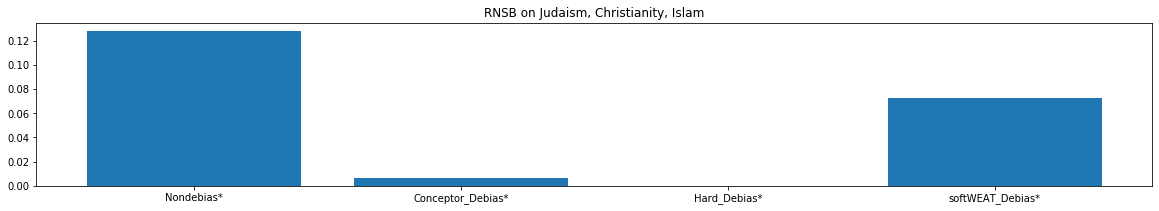

In [50]:
RNSB = [d[0] for d in Results.values()]
for key, value in Results.items():
    print(f' {key} : {value[0]}')
plt.figure(figsize=(20, 3))
plt.title('RNSB on Judaism, Christianity, Islam')
plt.bar(Results.keys(), RNSB)
plt.show()


 Nondebias* : 0
 Conceptor_Debias* : 0.018414037101185162
 Hard_Debias* : 0.01857421168741203
 softWEAT_Debias* : 0.037299573697205775


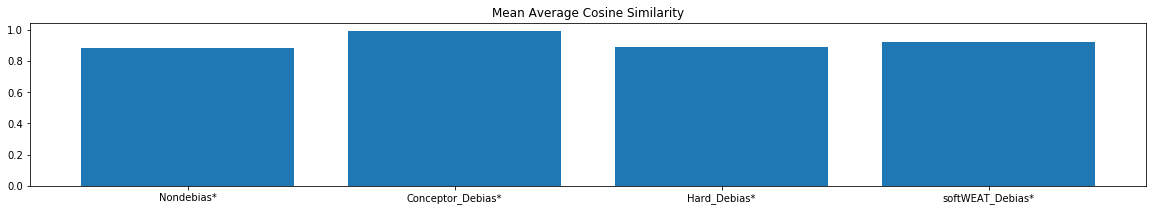

In [51]:
MAC = [d[2] for d in Results.values()]
for key, value in Results.items():
    print(f' {key} : {value[1]}')
plt.figure(figsize=(20, 3))
plt.title('Mean Average Cosine Similarity')
plt.bar(Results.keys(), MAC)
plt.show()


 Nondebias* : 0.8821258816966492
 Conceptor_Debias* : 0.9956381136554976
 Hard_Debias* : 0.8896109938367172
 softWEAT_Debias* : 0.9223449344414063


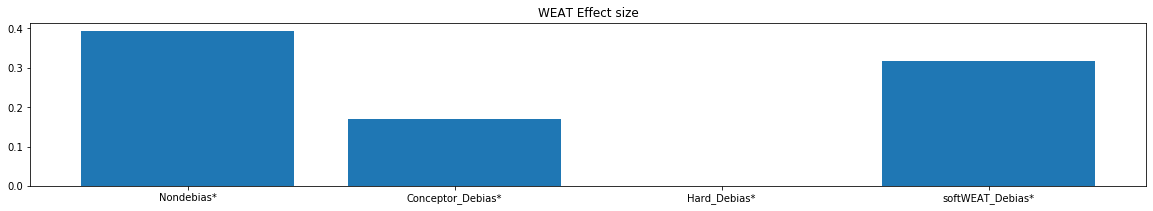

In [52]:
WEATD = [d[4] for d in Results.values()]
for key, value in Results.items():
    print(f' {key} : {value[2]}')
plt.figure(figsize=(20, 3))
plt.title('WEAT Effect size')
plt.bar(Results.keys(), WEATD)
plt.show()
